# Summer internship 

This notebook presents a code based on the research papper: "Euclid preparation: VII. Forecast validation for Euclid cosmological probes" in which the objective is to calculate de asocciated error of cosmological parameteres meassurements using the Fisher Matriz formalisim for forcasting probes. 

I suggest reading the pappers found on the folder titled "Research Pappers/" and instaling CAMB. For more information, visit https://camb.info/.

In [3]:
# necessary package import for code 

import sys
import os
import numpy as np
import scipy.integrate as integrate
import camb as camb
from matplotlib import pyplot as plt


# CAMB 

This section shows the intalation of CAMB and a basic familarization with CAMB packages and their usses.

In [4]:
# camb instalation

camb_path = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, camb_path)


print('Using CAMB %s installed at %s'%(camb.__version__, os.path.dirname(camb.__file__ )))

Using CAMB 1.3.6 installed at c:\ProgramData\Anaconda3\lib\site-packages\camb


# Cosmological Context

It is necessary for the comprehension of this internship to present the cosmological context in which the work will be done. For this purpose, I'll summarize the core theory, beggining with the description of the different **comsmological models and their asocciated parameters** that are important to us in this context.

## Background quantities 

Based on Einstein's field equations of **general relativity**, it is possible to derive the Friedmann equations which govern the expansion of space and describe the time evolution in homogeneus and isotropic models of the universe. The equations are: 

$H^2(t) = [\frac{\dot{a(t)}}{a(t)}^2] = \frac{8\pi G}{3}\rho(t) - \frac{Kc^2}{a^2(t)} \\$
$\frac{\dot{a(t)}}{a(t)} = -\frac{4\pi G}{3}[\rho(t) + 3\frac{\rho(t)}{c^2}$

Adding **redshift** as a scale factor; $z=a_0/a-1$ and normazalizing $a_0 =1$ which denotrs the present day valur of the scale factor, the **Hubble expassion rate $H(z)$** can be expressed as follows: 
$H(z) = H_0E(z)$ where $H_0$ is the Hubble parameter today, and $E(z)$ is the proper distance function.

To define **cosmological parameters** and work efficiently with them, we can definde the **density parameter** $\Omega_i(z) = \rho_i(z)/\rho_{crit}(z)$ where $ \rho_{crit}(z)$ is the critical density, derived from the Hubble expanssion rate and a spattialy flat geometry (K=0), and $i$ denotes a generic component. By also defining an **effective curvature density** parameter $\Omega_K(z)$, equation 1 takes de form:

$\sum_{i=1}^{N} \Omega_i(z) + \Omega_K(z) = 1$ whew the sum is over all N species consider in the model.

The Friedmann equations can be combined into an **energy conservation equation**. A solution of this equation requires to specify the properties og each energy component in the form of a equation of state $p=p(\rho)$ that is specified in terms of state parameters $w = p/\rho c^2$, which can be redshift dependent. 



In [5]:
# valores de Planck 2016 para testear las funciones

params_P18 = dict()
# crearemos diccionarios en donde estaran los parametros cosmologicos que
# queremos utilizar, es facil poder crear y modificar diccionarios

params_P18['Ob'] = 0.05   # Omega_b_0
params_P18['Om'] = 0.32  # Omega_m_0
params_P18['ns'] = 0.96605       # indice espectral
params_P18['ODE'] = 0.68   # Omega_DE_0
params_P18['sigma8'] = 0.816    # amplitud de densidades de fluctuación
params_P18['H0'] = 67.32      # 100h
params_P18['sum_mv'] = 0.06  # valor de masas de neutrino
params_P18['w_0'] = -1
params_P18['w_a'] = 0
params_P18['gamma'] = 0.55
params_P18['Ov'] = 0  # en este caso tomamos la densidad de radiación como nula

We base our models in the **standard model of cosmology:** $\Lambda CDM$, we can now define basic background quantities for this model which will define our future work:

The **matter energy density** in the form of baryons and cold dark matter particles will be describe by: $w_b = w_c = 0$. The photon radiation density is $w_{\gamma} =1/3$. For the purpouse of galaxy clustering and weak lensing measurements the radiation density $\Omega_{\gamma,0}$ is neglible. and we treat massive neutrinos as part of the total matter contribution: $\Omega_{m,0} = \Omega_{c,0} + \Omega_{b,0} + Omega_{v,0}$. 
In this context, cosmic acceleration requieres a fluid, with this we mean "dark energy" (DE) which has an equation of state $w_{DE} < -1/3$. Our model, assumes that this phenomenom is due to the pressence of the cosmological constant $\Lambda$ described by the equation of state $w_{\Lambda} = -1$ which corresponds to a time independent energy density $\rho_{\Lambda}$.


In [6]:
def Omega_Lambda(Omega_m, Omega_b, Omega_v):
    """La funcion Omega_Lambda nos entregara este parametro en base a los que
    tenemos, para esto tambien debemos calcular Omega c, un parametro que
    no se utilizara, por lo que no es necesario almacenar"""
    Omega_c = Omega_m - Omega_b
    OL = 1 - Omega_c - Omega_b - Omega_v
    return OL


def Omega_K_0(Omega_DE, Omega_m):
    """Omega_K_0 nos entrega este parametro que es depende de Omega DE y
    Omega m, en el caso de del modelo ΛCDM este valor es cero"""
    OK = 1 - (Omega_DE + Omega_m)
    return OK


def cosmological_parameters(cosmo_pars=dict()):
    """cosmological_parameters extrae los parametros necesarios para las
    el calculo de funciones E(z) y D(z), concadena estos parametros de manera
    que sean facil de utilizar, el default son los parametros de Planck 2018"""
    H0 = cosmo_pars.get('H0', params_P18['H0'])
    Om = cosmo_pars.get('Om', params_P18['Om'])
    Ob = cosmo_pars.get('Ob', params_P18['Ob'])
    Ov = cosmo_pars.get('Ov', params_P18['Ov'])
    ODE = cosmo_pars.get('ODE', params_P18['ODE'])
    OL = Omega_Lambda(Om, Ob, Ov)
    OK = Omega_K_0(ODE, Om)
    wa = cosmo_pars.get('wa', params_P18['w_a'])
    w0 = cosmo_pars.get('w0', params_P18['w_0'])
    return H0, Om, ODE, OL, OK, wa, w0

## Proper Distance Function $E(z)$ and Angular Diameter Distance Function $D(z)$

**Proper distance** and **Comoving distance** are two closely related distance measures used to define distances between objects.

Proper distance roughly corresponds to where a distant object would be at a specific moment of cosmological time, which can change over time due to the expansion of the universe. 

Comoving distance factors out the expansion of the universe, giving a distance that does not change in time due to the expansion of space, though this may change due to other, local factors, such as the motion of a galaxy within a cluster.

The  $\Lambda CDM$ model has fudamental problems, although it fits observations very well. This problems are known as: **The cosmological constant problem** and **The coincidence problem**. Because of this the model and its parameters cannot be predicted from physicial principles. 
It is needed a general scenarios for the component responsible for cosmic acceleration. This scenario postulates a **dynamical DE** with a redshift dependent equation of state parameter: 
$w_{DE}(z) = w_0 + w_a\frac{z}{1+z}$ with $w_0$ the present value of the equation of state and $w_a$ a meassure of its time variation.

In this case,the evolution od DE density obbeys: 
$\rho_{DE}(z) = \rho_{DE,0}(1+z)^{3(1+w_0+w_a)}exp[-3w_a\frac{z}{1+z}]$

Finally it is possible to denife the **proper distance function** $E(z)$ as:

$E(z) = \sqrt{\Omega_{m,0}(1+z)^3 +\Omega_{DE,0}(1+z)^{3(1+w_0+w_a)}exp[-3w_a\frac{z}{1+z}] + \Omega_{K,0}(1+z)^2}$

Where it is possible to recover the setting of the $\Lambda CDM$ model by setting $w_0 = -1$ and $w_a = 0$, in which case the proper distance function become;

$E(z) = \sqrt{\Omega_{m,0}(1+z)^3 +\Omega_{\Lambda,0}+ \Omega_{K,0}(1+z)^2}$


The comoving distance to an object redshift z can be computed as:

$r(z) = \frac{c}{H_0}\int_{0}^{z} \frac{dz}{E(z)}$

From comoving distance we can derive the **angular diameter distance** $D_A(z)$ which is the relation between the apparent angular size of an object and its true physical size in Euclidean space. The function is defined as:

   
$D_A(z) = 
     \begin{cases}
       (1+z)^{-1}\frac{c}{H_0}\frac{1}{\sqrt{|\Omega_{K,0}|}}sin[\sqrt{|\Omega_{K,0}|}\frac{H_0}{c}r(z) &\quad\text{if } \Omega_{K,0}\leq 0\\
       (1+z)^{-1}r(z) &\quad\text{if }\Omega_{K,0} =0 \\
       (1+z)^{-1}\frac{c}{H_0}\frac{1}{\sqrt{\Omega_{K,0}}}sin[\sqrt{\Omega_{K,0}}\frac{H_0}{c}r(z) &\quad\text{if } \Omega_{K,0}\geq 0\\
     \end{cases}    $

In [7]:
def E_arb(z, cosmo_pars=dict()):
    """E_arb es la función E(z) arbitraria para cualquier modelo cosmologico"""
    H0, Om, ODE, OL, Ok, wa, w0 = cosmological_parameters(cosmo_pars)
    exp = np.exp(-3*wa*(z/1+z))
    ind = 1 + wa + w0
    E = np.sqrt(Om*(1+z)**3 + ODE*((1+z)**(3*ind))*exp + Ok*(1+z)**2)
    return E


def E(z, cosmo_pars=dict()):
    """E es la función E(z) para el caso w0 = -1 y wa = 0"""
    H0, Om, ODE, OL, Ok, wa, w0 = cosmological_parameters(cosmo_pars)
    E = np.sqrt(Om*(1+z)**3 + OL + Ok*(1+z)**2)
    return E

In [8]:
# comoving distance to an object redshift z

def f_integral(z, cosmo_pars=dict()):
    """f_integral define la funcion dentro de la integral
    ocupada para el calculo de r(z)"""
    return 1/E_arb(z, cosmo_pars)


def r(z, cosmo_pars=dict()):
    """r calcula comoving distnace to an objecto redshift"""
    c = 300000  # km/s
    cte = c/params_P18['H0']  # h^-1 Mpc
    int = integrate.quad(f_integral, 0, z, args=cosmo_pars)
    r = cte*int[0]
    return r


# transverse comoving distance


def D(z, cosmo_pars=dict()):
    """La funcion D calcula transverse comoving distance para los distintos
    casos de el parametro Omgea_K_0"""
    c = 300000  # km/s
    H0, Om, ODE, OL, Ok, wa, w0 = cosmological_parameters(cosmo_pars)
    cte_1 = c/H0
    cte_2 = H0/c
    a = 1/(1+z)
    if Ok < 0:
        return a*(cte_1*(1/(np.abs(Ok)**(1/2))))*np.sin(
            np.abs(Ok)**(1/2)*cte_2*r(z, cosmo_pars))
    if Ok == 0:
        return a*r(z, cosmo_pars)
    if Ok > 0:
        return a*(cte_1*(1/(Ok**(1/2))))*np.sinh(
            (Ok**(1/2))*cte_2*r(z, cosmo_pars))
    else:
        return "Error"

# Plots
In the next section all the **plots** of the code will be displayed with a small description.


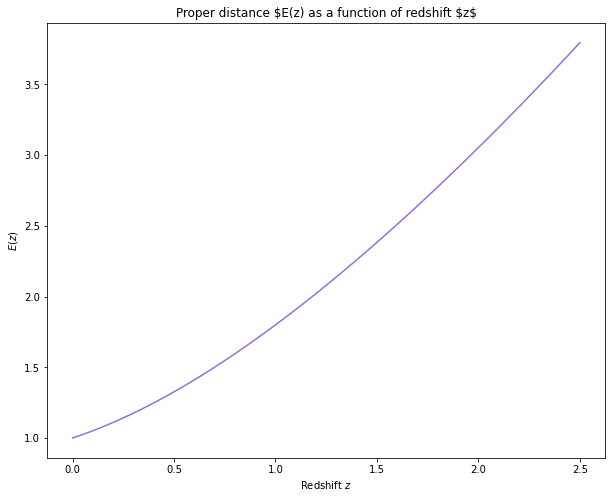

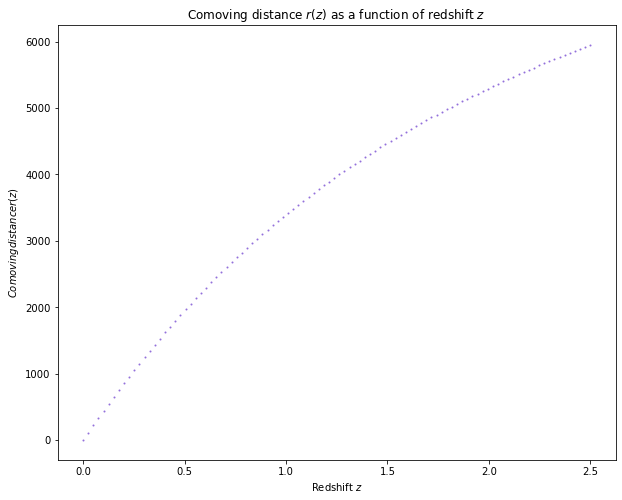

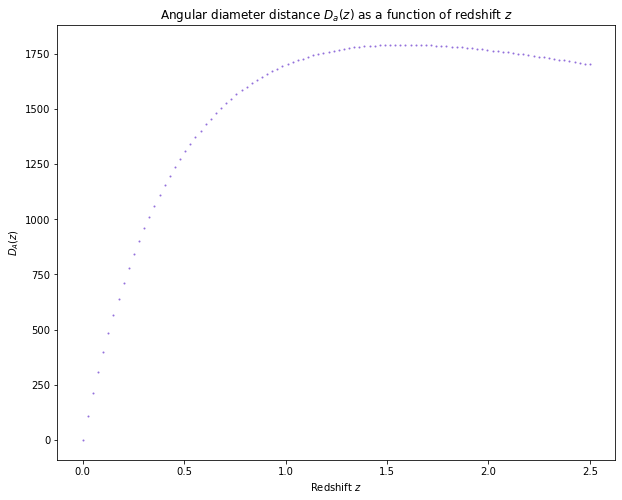

In [9]:
# all plots in the same row, share the y-axis.

z_arr = np.linspace(0, 2.5, 100)
fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))  

# Proper distance dependent on redshift plot
ax.plot(z_arr, E_arb(z_arr), label='$E(z)$', color='mediumpurple')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$E(z)$')
ax.set_title('Proper distance $E(z) as a function of redshift $z$')
plt.show()

# Comoving distance to an object redshift z plot

fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))
for z in z_arr:
    ax.scatter(z, r(z), s=1.0, label='$r(z)$', color='mediumpurple')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$Comoving distance r(z)$')
ax.set_title('Comoving distance $r(z)$ as a function of redshift $z$')
plt.show()

# Angular diameter distance to an object redshift z plot

fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))
for z in z_arr:
    ax.scatter(z, D(z), s=1.0, label='$D_A(z)$', color='mediumpurple')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$D_A(z)$')
ax.set_title('Angular diameter distance $D_a(z)$ as a function of redshift $z$')
plt.show()
